# Imports

In [0]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import nn
import numpy as np
from functools import partial
import matplotlib.pyplot as plt 
import time

# Constants

In [0]:
my_random_state = 42
BATCH_SIZE_default = 128
BATCH_SIZE_plot = 1024
eps_default = 1e-2
mode_default = 'l2'
lr_default = 1e-2

# Data generation and visualization

In [0]:
def gaussian_sampler_2d(gaussian_center, cov_matrix):
    mu_distr = MultivariateNormal(gaussian_center, cov_matrix)
    return mu_distr

def gaussian_data_sampling(gaussian_center, cov_matrix, data_num, device = None):
    sampler = gaussian_sampler_2d(gaussian_center, cov_matrix)
    data = sampler.sample(sample_shape=torch.Size([data_num]))
    if (device is not None):
      data = data.to(device)

    return data
    
def plot_data_gaussians(data_mu, data_nu):
    fig = plt.figure(figsize=(10,10))

    plt.xlabel(r'$x$') 
    plt.ylabel(r'$y$') 
    plt.title('1 and 8 gaussians') 

    plt.scatter(data_mu[:, 0], data_mu[:, 1], label = r'$\mu$-s gaussian', marker='+')
    plt.scatter(data_nu[:, 0], data_nu[:, 1], label = r'$\nu$-s gaussians', marker='+', color = 'r')

    plt.legend()
    plt.grid(True) 

def gaussian_data_sampling_nu(centers_nu, cov_matrix, BATCH_SIZE, random_state, device = None):
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    index_to_choice = np.random.randint(centers_nu.shape[0], size = BATCH_SIZE)
    data_nu = gaussian_data_sampling(centers_nu[index_to_choice[0]], cov_matrix, 1)
    for i in range(1, BATCH_SIZE):
        cur_data_nu = gaussian_data_sampling(centers_nu[index_to_choice[i]], cov_matrix, 1)
        data_nu = torch.cat((data_nu, cur_data_nu), 0)
    
    if (device is not None):
      data_nu = data_nu.to(device)

    return data_nu

def gaussian_data_sampling_mu(center_mu, cov_matrix, BATCH_SIZE, random_state, device = None):
    torch.manual_seed(random_state)
    return gaussian_data_sampling(center_mu, cov_matrix, BATCH_SIZE, device)

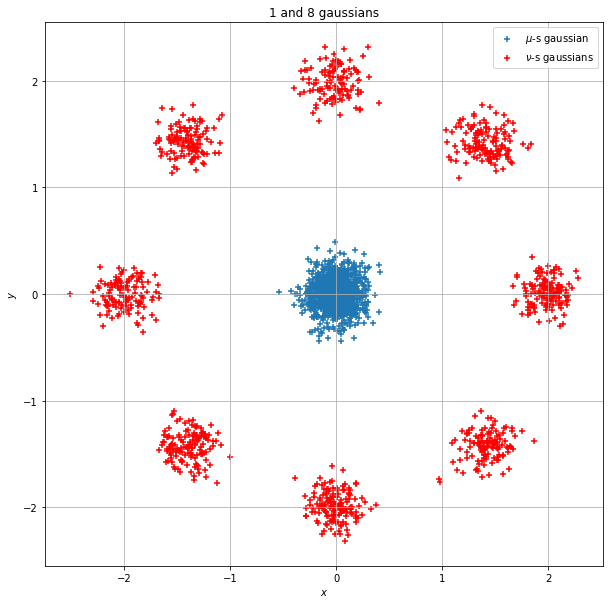

In [4]:
scale = 2.
nu_centers = [
            [1, 0],
            [-1, 0],
            [0, 1],
            [0, -1],
            [1./np.sqrt(2), 1./np.sqrt(2)],
            [1./np.sqrt(2), -1./np.sqrt(2)],
            [-1./np.sqrt(2), 1./np.sqrt(2)],
            [-1./np.sqrt(2), -1./np.sqrt(2)]
          ]
gaussian_num = len(nu_centers)
centers_nu_default = torch.Tensor([(scale*x,scale*y) for x,y in nu_centers])
center_mu_default = torch.zeros(2)
sigma = 0.02
init_cov_matrix = torch.eye(2)
cov_matrix_default = sigma*init_cov_matrix
#data_nu = data_generation(centers_nu[0], cov_matrix, data_num)
#data_num = 100
#for i in range(1, gaussian_num):
#    cur_data_nu = data_generation(centers_nu[i], cov_matrix, data_num)
#    data_nu = torch.cat((data_nu, cur_data_nu), 0)
data_nu_validate = gaussian_data_sampling_nu(centers_nu_default, cov_matrix_default, BATCH_SIZE_plot, my_random_state)

#data_mu_num = BATCH_SIZE // centers_nu.shape[0]
#data_mu = data_generation(center_mu, cov_matrix, data_mu_num)
data_mu_validate = gaussian_data_sampling_mu(center_mu_default, cov_matrix_default, BATCH_SIZE_plot, my_random_state)
plot_data_gaussians(data_mu_validate.numpy(), data_nu_validate.numpy())

# Neural nets for dual variables $u, v$

In [0]:
torch.manual_seed(my_random_state)
D_in = 2
D_out = 1
H = 20
u_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)
v_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

# Loss, its estimation and grads

In [0]:
def c_l2(x, y):
    return torch.dist(x, y, 2)**2

def d_l2(x, y):
    return torch.dist(x, y, 2)**2

def F_eps(x, y, u_net_in_x, v_net_in_y, c = c_l2, eps=eps_default, mode=mode_default):
    res = torch.zeros(1)
    if mode == 'l2':
        relu = nn.ReLU()
        val = relu(u_net_in_x + v_net_in_y - c(x, y))
        res = -(val**2)/(4*eps)
    if mode == 'entropy':
        val = (u_net_in_x + v_net_in_y - c(x, y))/eps
        res = -eps*torch.exp(val)
    return res

def H_eps(x, y, u_net_in_x, v_net_in_y, c = c_l2, eps=eps_default, mode=mode_default):
    res = torch.zeros(1)
    if mode == 'l2':
        relu = nn.ReLU()
        val = relu(u_net_in_x + v_net_in_y - c(x, y))
        res = val/(2*eps)
    if mode == 'entropy':
        val = (u_net_in_x + v_net_in_y - c(x, y))/eps
        res = torch.exp(val)
    return res

def grad_F_eps(x, y, u_net_in_x, v_net_in_y, c = c_l2, eps=eps_default, mode=mode_default):
    return -H_eps(x, y, u_net_in_x, v_net_in_y, c, eps, mode)

def loss_estimation(u_net, v_net, data_mu, data_nu, c = c_l2, eps=eps_default, mode=mode_default):
    num_estimators = data_mu.shape[0]
    loss_estimators = []
    for i in range(num_estimators):
        u_net_in_x = u_net(data_mu[i])
        v_net_in_y = v_net(data_nu[i])
        cur_loss = u_net_in_x + v_net_in_y + F_eps(data_mu[i], data_nu[i], u_net_in_x, v_net_in_y) 
        loss_estimators.append(cur_loss)
    #print(cur_loss)
    loss_estimators = torch.Tensor(loss_estimators)
    return torch.mean(loss_estimators)

def d_l2_mean_loss(f_net, data_mu, data_nu):
    map_result = f_net(data_mu)
    loss = d_l2(data_nu, map_result)/data_mu.shape[0]
    return loss

In [7]:
x = data_mu_validate[0]
y = data_mu_validate[1]
u_net_in_x = u_net(x)
v_net_in_y = v_net(y)
c_test = c_l2(x, y)
print(f"Testing c_l2 function: c({x}, {y}) = {c_test}")
F_eps_test = F_eps(x, y, u_net_in_x, v_net_in_y)
grad_F_eps_test = grad_F_eps(x, y, u_net_in_x, v_net_in_y)
x = x.detach().numpy()
y = y.detach().numpy()
u_net_in_x = u_net_in_x.detach().numpy()
v_net_in_y = v_net_in_y.detach().numpy()
F_eps_test = F_eps_test.detach().numpy()
grad_F_eps_test = grad_F_eps_test.detach().numpy()

print(f"Testing F_eps function, eps = {eps_default}:")
print(f"F({x}, {y}, {u_net_in_x}, {v_net_in_y}) = {F_eps_test}")
print(f"Testing grad_F_eps function, eps = {eps_default}:")
print(f"grad_F_esp({x}, {y}, {u_net_in_x}, {v_net_in_y}) = {grad_F_eps_test}")

data_nu = gaussian_data_sampling_nu(centers_nu_default, cov_matrix_default, BATCH_SIZE_default, my_random_state)
data_mu = gaussian_data_sampling_mu(center_mu_default, cov_matrix_default, BATCH_SIZE_default, my_random_state)
loss = loss_estimation(u_net, v_net, data_mu, data_nu)
print(f"Testing loss_estimation function, eps = {eps_default}:")
loss = loss.detach().numpy()
print(f"loss = {loss}")

Testing c_l2 function: c(tensor([0.2725, 0.2103]), tensor([ 0.1274, -0.2978])) = 0.2792266011238098
Testing F_eps function, eps = 0.01:
F([0.27250695 0.21033372], [ 0.12738064 -0.2977656 ], [-0.25494242], [0.08443502]) = [-0.]
Testing grad_F_eps function, eps = 0.01:
grad_F_esp([0.27250695 0.21033372], [ 0.12738064 -0.2977656 ], [-0.25494242], [0.08443502]) = [-0.]
Testing loss_estimation function, eps = 0.01:
loss = -0.07547716796398163


# Training $u$ and $v$ nets using Algorithm 1

In [0]:
device_default = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_sampling_nu_default = partial(gaussian_data_sampling_nu, 
                                   centers_nu = centers_nu_default, cov_matrix = cov_matrix_default, device = device_default)
data_sampling_mu_default = partial(gaussian_data_sampling_mu, 
                                   center_mu = center_mu_default, cov_matrix = cov_matrix_default, device = device_default)
data_mu_validate_default = gaussian_data_sampling_mu(center_mu_default, cov_matrix_default, BATCH_SIZE_plot, my_random_state, device = device_default)
data_nu_validate_default = gaussian_data_sampling_nu(centers_nu_default, cov_matrix_default, BATCH_SIZE_plot, my_random_state, device = device_default)


In [0]:
def stochastic_OT_computation(num_steps, random_states_arr, u_net, v_net, 
                              data_sampling_nu = data_sampling_nu_default,
                              data_sampling_mu = data_sampling_mu_default,
                              BATCH_SIZE = BATCH_SIZE_default, lr = lr_default, 
                              eps = eps_default, c = c_l2, mode=mode_default,
                              data_mu_validate = data_mu_validate_default, 
                              data_nu_validate = data_nu_validate_default,
                              loss_arr_batch = [],
                              loss_arr_validate = [], 
                              device = None):
    if (device is not None):
      u_net.to(device)
      v_net.to(device)

    #loss_arr_batch = []
    #loss_arr_validate = []
    for num_step in range(num_steps):
        print("------------------------------")
        print(f"num_step = {num_step}")
        data_nu = data_sampling_nu(BATCH_SIZE = BATCH_SIZE, random_state = random_states_arr[num_step])
        data_mu = data_sampling_mu(BATCH_SIZE = BATCH_SIZE, random_state = random_states_arr[num_step])
        #data_nu = data_nu.to(device)
        #data_mu = data_mu.to(device)
        
        u_params_dict = {params_name: params for params_name, params in zip(u_net.state_dict(), 
                                                                         u_net.parameters())}
        v_params_dict = {params_name: params for params_name, params in zip(v_net.state_dict(), 
                                                                         v_net.parameters())}
        
        #u_upd_grad_dict = {params_name: torch.zeros_like(params.grad) 
        #                   for params_name, params in zip(u_net.state_dict(), u_net.parameters())}
        #v_upd_grad_dict = {params_name: torch.zeros_like(params.grad) 
        #                   for params_name, params in zip(v_net.state_dict(), v_net.parameters())}
        u_upd_grad_dict = u_params_dict
        v_upd_grad_dict = v_params_dict

        start_time = time.time()
        
        for i in range(BATCH_SIZE):
            for j in range(BATCH_SIZE):
                #print(f"i = {i}, j = {j}, calculation gradient")
                x = data_mu[i]
                y = data_nu[j]
                
                #x = x.to(device)
                #y = y.to(device)

                u_net.zero_grad()
                u_net_in_x = u_net(x)
                u_net_in_x.backward()

                v_net.zero_grad()
                v_net_in_y = v_net(y)
                v_net_in_y.backward()

                grad_F_eps_test = grad_F_eps(x, y, u_net_in_x, v_net_in_y, c = c, eps = eps, mode = mode)

                u_grad_dict = {params_name: params.grad*(1 +  grad_F_eps_test)*lr
                               for params_name, params in zip(u_net.state_dict(), u_net.parameters())}
                v_grad_dict = {params_name: params.grad*(1 +  grad_F_eps_test)*lr 
                               for params_name, params in zip(v_net.state_dict(), v_net.parameters())}

                for u_key in u_grad_dict.keys():
                    u_upd_grad_dict[u_key] = u_upd_grad_dict[u_key] + u_grad_dict[u_key]
                    
                for v_key in v_grad_dict.keys():
                    v_upd_grad_dict[v_key] = v_upd_grad_dict[v_key] + v_grad_dict[v_key]
        
        for params_name, params in u_net.state_dict().items():
            u_net.state_dict()[params_name].data.copy_(u_upd_grad_dict[params_name])
            
        for params_name, params in v_net.state_dict().items():
            v_net.state_dict()[params_name].data.copy_(v_upd_grad_dict[params_name])

        end_time = time.time()
        consumed_time = end_time - start_time
        print(f"Consumed time = {consumed_time} seconds")
            
        loss_batch = loss_estimation(u_net, v_net, data_mu, data_nu, c = c, eps = eps, mode = mode).item()
        print(f"Loss estimation on sampled data = {loss_batch}")

        loss_validate = loss_estimation(u_net, v_net, data_mu_validate, data_nu_validate, c = c, eps = eps, mode = mode).item()
        print(f"Loss estimation on validation data = {loss_validate}")
        
        loss_arr_batch.append(loss_batch)
        loss_arr_validate.append(loss_validate)
    
    #return loss_arr_batch, loss_arr_validate

In [10]:
torch.manual_seed(my_random_state)
D_in = 2
D_out = 1
H = 20
u_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)
v_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

lr = 2e-6
eps = 1e-2
num_steps = 100
random_states_arr = range(num_steps)
loss_arr_batch = []
loss_arr_validate = []
stochastic_OT_computation(num_steps, random_states_arr, u_net, v_net, lr = lr, eps = eps, loss_arr_batch = loss_arr_batch, loss_arr_validate = loss_arr_validate, device = device_default)

------------------------------
num_step = 0
Consumed time = 33.50866413116455 seconds
Loss estimation on sampled data = 0.14802215993404388
Loss estimation on validation data = 0.15278854966163635
------------------------------
num_step = 1
Consumed time = 34.28612565994263 seconds
Loss estimation on sampled data = 0.42391902208328247
Loss estimation on validation data = 0.4030727744102478
------------------------------
num_step = 2


KeyboardInterrupt: ignored

In [16]:
torch.manual_seed(my_random_state)
D_in = 2
D_out = 1
H = 20
u_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)
v_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

lr = 2e-6
eps = 1e-2
num_steps = 100
random_states_arr = range(num_steps)
loss_arr_batch = []
loss_arr_validate = []

data_sampling_nu_cpu = partial(gaussian_data_sampling_nu, 
                                   centers_nu = centers_nu_default, cov_matrix = cov_matrix_default)
data_sampling_mu_cpu = partial(gaussian_data_sampling_mu, 
                                   center_mu = center_mu_default, cov_matrix = cov_matrix_default)
data_mu_validate_cpu = gaussian_data_sampling_mu(center_mu_default, cov_matrix_default, BATCH_SIZE_plot, my_random_state)
data_nu_validate_cpu = gaussian_data_sampling_nu(centers_nu_default, cov_matrix_default, BATCH_SIZE_plot, my_random_state)

stochastic_OT_computation(num_steps, random_states_arr, u_net, v_net, 
                          data_sampling_nu = data_sampling_nu_cpu,
                          data_sampling_mu = data_sampling_mu_cpu,
                          lr = lr, eps = eps, 
                          data_mu_validate = data_mu_validate_cpu, 
                          data_nu_validate = data_nu_validate_cpu,
                          loss_arr_batch = loss_arr_batch, loss_arr_validate = loss_arr_validate)

------------------------------
num_step = 0
Consumed time = 18.949562788009644 seconds
Loss estimation on sampled data = 0.14802215993404388
Loss estimation on validation data = 0.15278856456279755
------------------------------
num_step = 1
Consumed time = 17.811297178268433 seconds
Loss estimation on sampled data = 0.42391902208328247
Loss estimation on validation data = 0.4030728042125702
------------------------------
num_step = 2
Consumed time = 18.747682809829712 seconds
Loss estimation on sampled data = 0.6860796213150024
Loss estimation on validation data = 0.6469764113426208
------------------------------
num_step = 3
Consumed time = 18.535800218582153 seconds
Loss estimation on sampled data = 0.8345731496810913
Loss estimation on validation data = 0.8799247145652771
------------------------------
num_step = 4
Consumed time = 17.95370626449585 seconds
Loss estimation on sampled data = 1.1622846126556396
Loss estimation on validation data = 1.1284877061843872
------------------

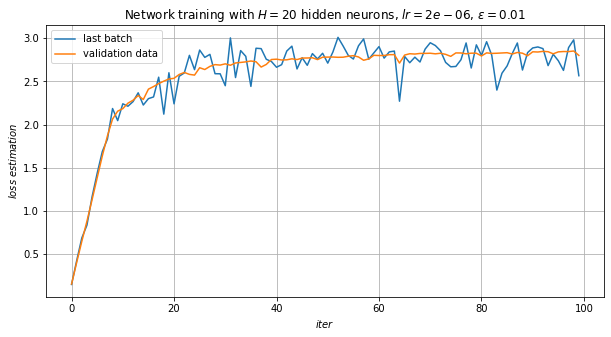

In [18]:
fig = plt.figure(figsize=(10,5))

plt.xlabel(r'$iter$') 
plt.ylabel(r'$loss \; estimation$') 
plt.title(fr'Network training with $H = {H}$ hidden neurons, $lr = {lr}$, $\varepsilon = {1e-2}$') 

plt.plot(random_states_arr, loss_arr_batch, label = r'last batch')
plt.plot(random_states_arr, loss_arr_validate, label = r'validation data')

plt.legend()
plt.grid(True) 

In [12]:
torch.manual_seed(my_random_state)
D_in = 2
D_out = 1
H = 20
u_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)
v_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

lr = 2e-6
eps = 1e-2
num_steps = 90
random_states_arr = range(num_steps)
loss_arr_batch = []
loss_arr_validate = []

data_sampling_nu_cpu = partial(gaussian_data_sampling_nu, 
                                   centers_nu = centers_nu_default, cov_matrix = cov_matrix_default)
data_sampling_mu_cpu = partial(gaussian_data_sampling_mu, 
                                   center_mu = center_mu_default, cov_matrix = cov_matrix_default)
data_mu_validate_cpu = gaussian_data_sampling_mu(center_mu_default, cov_matrix_default, BATCH_SIZE_plot, my_random_state)
data_nu_validate_cpu = gaussian_data_sampling_nu(centers_nu_default, cov_matrix_default, BATCH_SIZE_plot, my_random_state)

stochastic_OT_computation(num_steps, random_states_arr, u_net, v_net, 
                          data_sampling_nu = data_sampling_nu_cpu,
                          data_sampling_mu = data_sampling_mu_cpu,
                          lr = lr, eps = eps, 
                          data_mu_validate = data_mu_validate_cpu, 
                          data_nu_validate = data_nu_validate_cpu,
                          loss_arr_batch = loss_arr_batch, loss_arr_validate = loss_arr_validate)

------------------------------
num_step = 0
Consumed time = 18.282503128051758 seconds
Loss estimation on sampled data = 0.14802215993404388
Loss estimation on validation data = 0.15278856456279755
------------------------------
num_step = 1
Consumed time = 17.31783103942871 seconds
Loss estimation on sampled data = 0.42391902208328247
Loss estimation on validation data = 0.4030728042125702
------------------------------
num_step = 2
Consumed time = 17.4210205078125 seconds
Loss estimation on sampled data = 0.6860796213150024
Loss estimation on validation data = 0.6469764113426208
------------------------------
num_step = 3
Consumed time = 17.10130286216736 seconds
Loss estimation on sampled data = 0.8345731496810913
Loss estimation on validation data = 0.8799247741699219
------------------------------
num_step = 4
Consumed time = 16.978771209716797 seconds
Loss estimation on sampled data = 1.1622846126556396
Loss estimation on validation data = 1.1284877061843872
---------------------

In [28]:
torch.manual_seed(my_random_state)
D_in = 2
D_out = 1
H = 50
u_net_deep = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)
v_net_deep = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

lr = 2e-6
eps = 1e-2
num_steps = 10
random_states_arr = range(num_steps)
loss_arr_batch = []
loss_arr_validate = []

data_sampling_nu_cpu = partial(gaussian_data_sampling_nu, 
                                   centers_nu = centers_nu_default, cov_matrix = cov_matrix_default)
data_sampling_mu_cpu = partial(gaussian_data_sampling_mu, 
                                   center_mu = center_mu_default, cov_matrix = cov_matrix_default)
data_mu_validate_cpu = gaussian_data_sampling_mu(center_mu_default, cov_matrix_default, BATCH_SIZE_plot, my_random_state)
data_nu_validate_cpu = gaussian_data_sampling_nu(centers_nu_default, cov_matrix_default, BATCH_SIZE_plot, my_random_state)

stochastic_OT_computation(num_steps, random_states_arr, u_net_deep, v_net_deep, 
                          data_sampling_nu = data_sampling_nu_cpu,
                          data_sampling_mu = data_sampling_mu_cpu,
                          lr = lr, eps = eps, 
                          data_mu_validate = data_mu_validate_cpu, 
                          data_nu_validate = data_nu_validate_cpu,
                          loss_arr_batch = loss_arr_batch, loss_arr_validate = loss_arr_validate)

------------------------------
num_step = 0
Consumed time = 28.65029501914978 seconds
Loss estimation on sampled data = 0.2597160339355469
Loss estimation on validation data = 0.2593729794025421
------------------------------
num_step = 1
Consumed time = 28.686736583709717 seconds
Loss estimation on sampled data = 0.386341392993927
Loss estimation on validation data = 0.38607174158096313
------------------------------
num_step = 2
Consumed time = 28.620063066482544 seconds
Loss estimation on sampled data = 0.5157472491264343
Loss estimation on validation data = 0.5131034255027771
------------------------------
num_step = 3
Consumed time = 28.261534214019775 seconds
Loss estimation on sampled data = 0.6406910419464111
Loss estimation on validation data = 0.6417846083641052
------------------------------
num_step = 4
Consumed time = 27.948958158493042 seconds
Loss estimation on sampled data = 0.7747925519943237
Loss estimation on validation data = 0.7751910090446472
---------------------

# Neural net for result mapping $f_{\theta}$

In [0]:
torch.manual_seed(my_random_state)
D_in = 2
f_D_out = 2
H = 128
f_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, 2*H),
    torch.nn.ReLU(),
    torch.nn.Linear(2*H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, f_D_out),
)

# Training resulting mapping $f_{\theta}$ using Algorithm 2

In [0]:
def optimal_map_learning_with_SGD(num_steps, random_states_arr, u_net, v_net, f_net,
                              data_sampling_nu = data_sampling_nu_default,
                              data_sampling_mu = data_sampling_mu_default,
                              BATCH_SIZE = BATCH_SIZE_default, lr = lr_default, 
                              eps = eps_default, c = c_l2, mode=mode_default,
                              d = d_l2,
                              data_mu_validate = data_mu_validate_default, 
                              data_nu_validate = data_nu_validate_default,
                              loss_arr_batch = [],
                              loss_arr_validate = [], 
                              device = None):
    if (device is not None):
      f_net.to(device)

    #loss_arr_batch = []
    #loss_arr_validate = []
    for num_step in range(num_steps):
        print("------------------------------")
        print(f"num_step = {num_step}")
        data_nu = data_sampling_nu(BATCH_SIZE = BATCH_SIZE, random_state = random_states_arr[num_step])
        data_mu = data_sampling_mu(BATCH_SIZE = BATCH_SIZE, random_state = random_states_arr[num_step])
        #data_nu = data_nu.to(device)
        #data_mu = data_mu.to(device)
        
        f_params_dict = {params_name: params for params_name, params in zip(f_net.state_dict(), 
                                                                         f_net.parameters())}
        
        f_upd_grad_dict = f_params_dict

        start_time = time.time()
        
        for i in range(BATCH_SIZE):
            for j in range(BATCH_SIZE):
                #print(f"i = {i}, j = {j}, calculation gradient")
                x = data_mu[i]
                y = data_nu[j]
                
                #x = x.to(device)
                #y = y.to(device)

                u_net_in_x = u_net(x)

                v_net_in_y = v_net(y)

                H_eps_test = H_eps(x, y, u_net_in_x, v_net_in_y, c = c, eps = eps, mode = mode)

                f_net.zero_grad()
                map_result = f_net(x)

                cur_loss = d(map_result, y)
                cur_loss.backward()

                f_grad_dict = {params_name: params.grad*H_eps_test*lr
                               for params_name, params in zip(f_net.state_dict(), f_net.parameters())}

                for f_key in f_grad_dict.keys():
                    f_upd_grad_dict[f_key] = f_upd_grad_dict[f_key] - f_grad_dict[f_key]
        
        for params_name, params in u_net.state_dict().items():
            f_net.state_dict()[params_name].data.copy_(f_upd_grad_dict[params_name])

        end_time = time.time()
        consumed_time = end_time - start_time
        print(f"Consumed time = {consumed_time} seconds")
            
        loss_batch = d_l2_mean_loss(f_net, data_mu, data_nu).item()
        print(f"Loss estimation on sampled data = {loss_batch}")

        loss_validate = d_l2_mean_loss(f_net, data_mu_validate, data_nu_validate).item()
        print(f"Loss estimation on validation data = {loss_validate}")
        
        loss_arr_batch.append(loss_batch)
        loss_arr_validate.append(loss_validate)

In [32]:
torch.manual_seed(my_random_state)
D_in = 2
f_D_out = 2
H = 128
f_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, 2*H),
    torch.nn.ReLU(),
    torch.nn.Linear(2*H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, f_D_out),
)

lr = 1e-5
eps = 1e-2
num_steps = 10
shift = 1000
f_random_states_arr = range(shift, shift + num_steps)
f_loss_arr_batch = []
f_loss_arr_validate = []

data_sampling_nu_cpu = partial(gaussian_data_sampling_nu, 
                                   centers_nu = centers_nu_default, cov_matrix = cov_matrix_default)
data_sampling_mu_cpu = partial(gaussian_data_sampling_mu, 
                                   center_mu = center_mu_default, cov_matrix = cov_matrix_default)
data_mu_validate_cpu = gaussian_data_sampling_mu(center_mu_default, cov_matrix_default, BATCH_SIZE_plot, my_random_state)
data_nu_validate_cpu = gaussian_data_sampling_nu(centers_nu_default, cov_matrix_default, BATCH_SIZE_plot, my_random_state)

optimal_map_learning_with_SGD(num_steps, f_random_states_arr, u_net, v_net, f_net,
                              data_sampling_nu = data_sampling_nu_cpu,
                              data_sampling_mu = data_sampling_mu_cpu,
                              lr = lr, eps = eps, 
                              data_mu_validate = data_mu_validate_cpu, 
                              data_nu_validate = data_nu_validate_cpu,
                              loss_arr_batch = f_loss_arr_batch, loss_arr_validate = f_loss_arr_validate)

------------------------------
num_step = 0
Consumed time = 23.96519708633423 seconds
Loss estimation on sampled data = 4.065133094787598
Loss estimation on validation data = 4.0121588706970215
------------------------------
num_step = 1
Consumed time = 24.159698009490967 seconds
Loss estimation on sampled data = 4.102294445037842
Loss estimation on validation data = 4.0159430503845215
------------------------------
num_step = 2
Consumed time = 24.041806936264038 seconds
Loss estimation on sampled data = 4.067490100860596
Loss estimation on validation data = 4.017062187194824
------------------------------
num_step = 3
Consumed time = 24.002230167388916 seconds
Loss estimation on sampled data = 3.9555938243865967
Loss estimation on validation data = 4.01576566696167
------------------------------
num_step = 4
Consumed time = 24.089920043945312 seconds
Loss estimation on sampled data = 4.123157501220703
Loss estimation on validation data = 4.016829013824463
-----------------------------

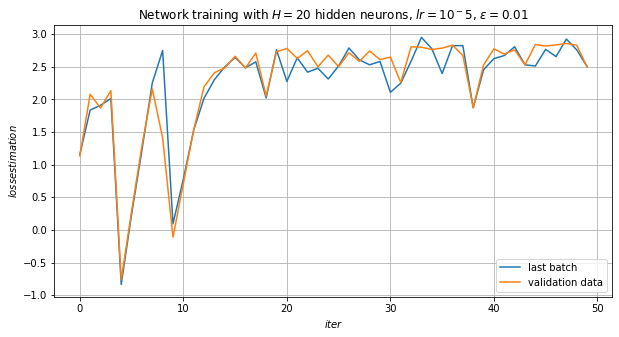

In [0]:
fig = plt.figure(figsize=(10,5))

plt.xlabel(r'$iter$') 
plt.ylabel(r'$loss estimation$') 
plt.title(fr'Network training with $H = {H}$ hidden neurons, $lr = 10^{-5}$, $\varepsilon = {1e-2}$') 

plt.plot(random_states_arr, loss_arr_batch, label = r'last batch')
plt.plot(random_states_arr, loss_arr_validate, label = r'validation data')

plt.legend()
plt.grid(True) 

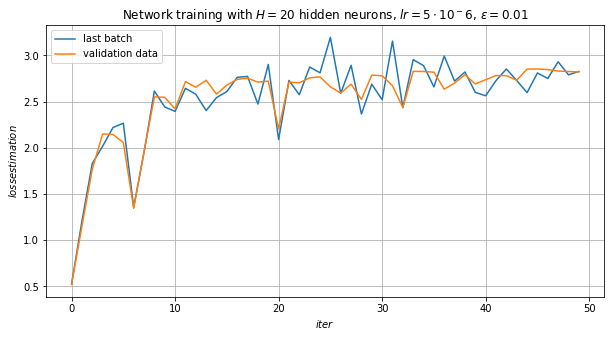

In [0]:
fig = plt.figure(figsize=(10,5))

plt.xlabel(r'$iter$') 
plt.ylabel(r'$loss estimation$') 
plt.title(fr'Network training with $H = {H}$ hidden neurons, $lr = 5 \cdot 10^{-6}$, $\varepsilon = {1e-2}$') 

plt.plot(random_states_arr, loss_arr_batch, label = r'last batch')
plt.plot(random_states_arr, loss_arr_validate, label = r'validation data')

plt.legend()
plt.grid(True) 

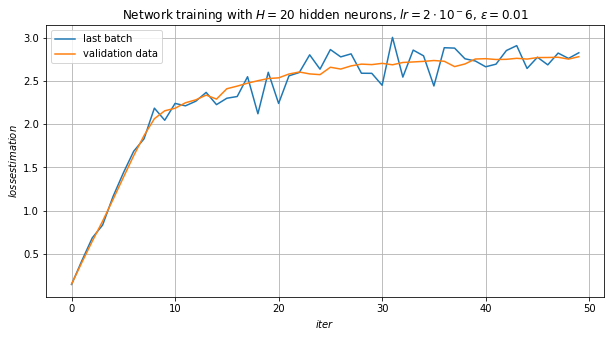

In [0]:
fig = plt.figure(figsize=(10,5))

plt.xlabel(r'$iter$') 
plt.ylabel(r'$loss estimation$') 
plt.title(fr'Network training with $H = {H}$ hidden neurons, $lr = 2 \cdot 10^{-6}$, $\varepsilon = {1e-2}$') 

plt.plot(random_states_arr, loss_arr_batch, label = r'last batch')
plt.plot(random_states_arr, loss_arr_validate, label = r'validation data')

plt.legend()
plt.grid(True) 